# **Survival Analysis for Colorectal Cancer Patients**

## **Imports**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
import lifelines

## **EDA**

In [2]:
patient_data = pd.read_csv("data/Colorectal Cancer Patient Data.csv")
gene_expression_data = pd.read_csv("data/Colorectal Cancer Gene Expression Data.csv")
display(patient_data.info())
display(gene_expression_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       63 non-null     int64  
 1   ID_REF           62 non-null     object 
 2   Age (in years)   62 non-null     float64
 3   Dukes Stage      62 non-null     object 
 4   Gender           62 non-null     object 
 5   Location         62 non-null     object 
 6   DFS (in months)  62 non-null     float64
 7   DFS event        62 non-null     float64
 8   Adj_Radio        62 non-null     float64
 9   Adj_Chem         62 non-null     float64
dtypes: float64(5), int64(1), object(4)
memory usage: 5.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 64 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1935 non-null   int64  
 1   ID_REF      1935 non-null   object 
 2   GSM877126   1935 non-null   float64
 3   GSM877127   1935 non-null   float64
 4   GSM877128   1935 non-null   float64
 5   GSM877129   1935 non-null   float64
 6   GSM877130   1935 non-null   float64
 7   GSM877131   1935 non-null   float64
 8   GSM877132   1935 non-null   float64
 9   GSM877133   1935 non-null   float64
 10  GSM877134   1935 non-null   float64
 11  GSM877135   1935 non-null   float64
 12  GSM877136   1935 non-null   float64
 13  GSM877137   1935 non-null   float64
 14  GSM877138   1935 non-null   float64
 15  GSM877139   1935 non-null   float64
 16  GSM877140   1935 non-null   float64
 17  GSM877141   1935 non-null   float64
 18  GSM877142   1935 non-null   float64
 19  GSM877143   1935 non-null  

None

In [3]:
# Catch ID_REF from patient_data
patient_ids = list(patient_data['ID_REF'].dropna())

# Select relative columns from gene_expression_data
filtered_gene_expression = gene_expression_data[['ID_REF'] + patient_ids]

In [4]:
# Transposed gene_expression_data
transposed_gene_expression = filtered_gene_expression.set_index('ID_REF').T

# Use PCA to decreasing the dimension
pca = PCA(n_components=10)
gene_data_pca = pca.fit_transform(transposed_gene_expression)
gene_data_pca_df = pd.DataFrame(
    gene_data_pca, 
    index=transposed_gene_expression.index,
    columns=[f'PC{i+1}' for i in range(gene_data_pca.shape[1])]
)
gene_data_pca_df.index.name = 'ID_REF'

In [5]:
# Merge data by ID_REF
cancer_df = pd.merge(patient_data, gene_data_pca_df, on='ID_REF', how='inner')
display(cancer_df.head())

,Unnamed: 0,ID_REF,Age (in years),Dukes Stage,Gender,Location,DFS (in months),DFS event,Adj_Radio,Adj_Chem,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0,GSM877126,62.0,A,Male,Left,108.0,0.0,1.0,0.0,10.034968,-2.563519,0.553875,3.781413,5.493621,2.161225,0.752841,-1.176426,-1.026985,0.714158
1,1,GSM877127,77.0,B,Male,Left,40.0,1.0,1.0,0.0,3.952716,5.896752,-9.499336,-8.131562,-1.403260,3.904712,2.336202,3.467337,1.288390,4.268305
2,2,GSM877128,66.0,C,Female,Left,49.0,0.0,1.0,0.0,5.775722,-3.307521,-1.513594,1.629085,0.304471,0.556662,-1.021941,2.807646,-6.958469,2.117333
3,3,GSM877129,72.0,D,Female,Left,45.0,0.0,1.0,1.0,12.069907,-3.573937,0.164489,0.898278,-0.300936,-1.255239,-1.398750,4.986051,1.149399,-4.380219
4,4,GSM877130,75.0,C,Male,Left,40.0,0.0,0.0,1.0,0.703947,5.934475,4.480404,-1.632966,2.699608,0.046931,3.903217,2.261321,0.276052,0.103352


In [6]:
# Drop columns: "unnamed: 0", "ID_REF"
cancer_df = cancer_df.drop(columns=["Unnamed: 0", "ID_REF"], errors='ignore')

In [7]:
display(cancer_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age (in years)   62 non-null     float64
 1   Dukes Stage      62 non-null     object 
 2   Gender           62 non-null     object 
 3   Location         62 non-null     object 
 4   DFS (in months)  62 non-null     float64
 5   DFS event        62 non-null     float64
 6   Adj_Radio        62 non-null     float64
 7   Adj_Chem         62 non-null     float64
 8   PC1              62 non-null     float64
 9   PC2              62 non-null     float64
 10  PC3              62 non-null     float64
 11  PC4              62 non-null     float64
 12  PC5              62 non-null     float64
 13  PC6              62 non-null     float64
 14  PC7              62 non-null     float64
 15  PC8              62 non-null     float64
 16  PC9              62 non-null     float64
 17  PC10             6

None

In [8]:
display(cancer_df.describe())

,Age (in years),DFS (in months),DFS event,Adj_Radio,Adj_Chem,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
count,62.000000,62.000000,62.000000,62.000000,62.000000,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01
mean,61.112903,41.774194,0.596774,0.532258,0.483871,1.396732e-16,5.873438e-16,1.224827e-15,-8.523648e-16,-4.575193e-16,-1.031433e-15,1.840821e-15,6.750872e-16,1.597289e-15,5.748090e-16
std,9.581582,26.288076,0.494550,0.503032,0.503819,5.984986e+00,5.448934e+00,5.289646e+00,3.707399e+00,3.560829e+00,3.043301e+00,2.940728e+00,2.866683e+00,2.743363e+00,2.685712e+00
min,28.000000,4.000000,0.000000,0.000000,0.000000,-8.734558e+00,-1.009725e+01,-1.348926e+01,-8.131562e+00,-7.391162e+00,-6.953637e+00,-9.703805e+00,-8.636894e+00,-6.958469e+00,-6.431775e+00
25%,56.250000,19.500000,0.000000,0.000000,0.000000,-4.910179e+00,-3.490434e+00,-2.602438e+00,-2.733854e+00,-2.119044e+00,-1.494732e+00,-1.371080e+00,-1.567581e+00,-1.749306e+00,-1.176909e+00
50%,62.000000,38.000000,1.000000,1.000000,0.000000,-1.209003e+00,-8.250291e-01,1.109725e-01,-3.681112e-01,-2.003669e-01,2.393834e-02,4.053066e-01,-1.945727e-02,3.396703e-01,1.940125e-01
75%,67.000000,57.500000,1.000000,1.000000,1.000000,4.018253e+00,2.732209e+00,2.627808e+00,2.202249e+00,1.277923e+00,2.113257e+00,1.727573e+00,2.281265e+00,1.928400e+00,9.546835e-01
max,78.000000,108.000000,1.000000,1.000000,1.000000,1.345357e+01,1.610485e+01,1.591137e+01,9.788178e+00,1.894016e+01,7.105774e+00,6.355329e+00,5.528039e+00,4.704187e+00,8.048213e+00


- **Age Distribution**:
   - Patients are mostly older (median: 62 years), with a moderately small spread.

- **DFS (Disease-Free Survival)**:
   - DFS shows high variability, ranging from very short (4 months) to very long (108 months).
   - Median DFS is 38 months.

- **Treatment Distribution**:
   - Radiotherapy (`Adj_Radio`) and chemotherapy (`Adj_Chem`) are evenly distributed across the population (~53% and ~48%, respectively).

In [9]:
# Count missing values
display(cancer_df.isnull().sum())

Age (in years)     0
Dukes Stage        0
Gender             0
Location           0
DFS (in months)    0
DFS event          0
Adj_Radio          0
Adj_Chem           0
PC1                0
PC2                0
PC3                0
PC4                0
PC5                0
PC6                0
PC7                0
PC8                0
PC9                0
PC10               0
dtype: int64

- Each column (`Age (in years)`, `Dukes Stage`, `Gender`, `Location`, `DFS (in months)`, `DFS event`, `Adj_Radio`, `Adj_Chem`, `PC1`-`PC10`) has **0 missing entries**.

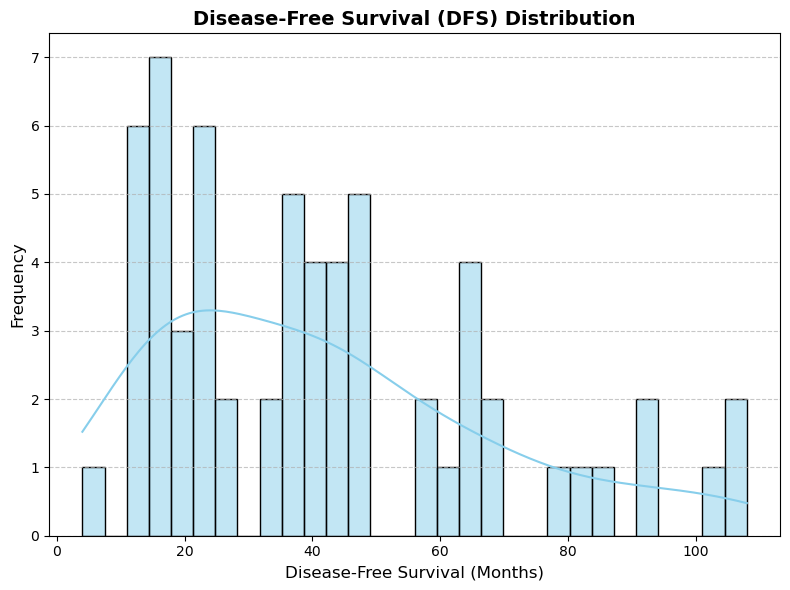

In [10]:
# Plot the histogram using Seaborn for better aesthetics
plt.figure(figsize=(8, 6))
sns.histplot(
    data=cancer_df, 
    x='DFS (in months)', 
    bins=30, 
    kde=True,
    color='skyblue', 
    edgecolor='black'
)

plt.title("Disease-Free Survival (DFS) Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Disease-Free Survival (Months)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

- **Distribution Shape**:
   - The distribution of DFS (in months) is **right-skewed**, with most patients having shorter DFS durations.
   - A small number of patients have DFS extending to 100+ months.

- **Frequency Peaks**:
   - There are noticeable peaks around 10–20 months and 50–60 months, indicating clusters of patients with shorter and moderate DFS durations.

- **Spread**:
   - DFS durations range from **4 months (minimum)** to **108 months (maximum)**.
   - Most values are concentrated below 60 months, as indicated by the density curve.

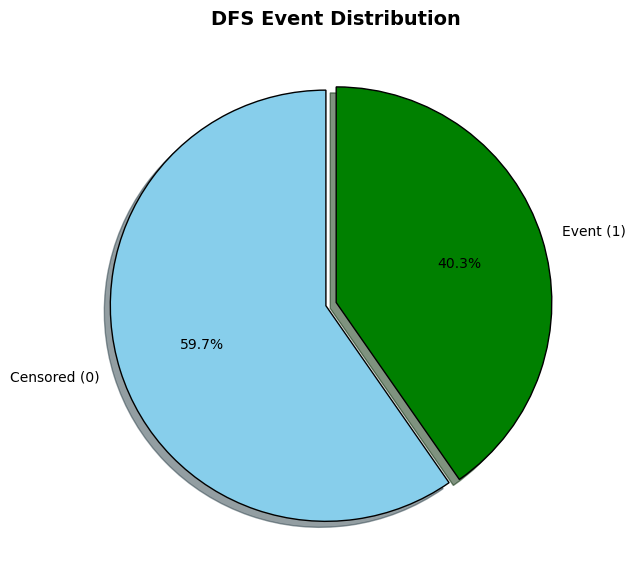

In [11]:
# Count the values for DFS event
dfs_event_counts = cancer_df['DFS event'].value_counts()

fig, ax = plt.subplots(figsize=(7, 7))
colors = ['skyblue', 'green']
explode = [0.05, 0]

ax.pie(
    dfs_event_counts,
    labels=['Censored (0)', 'Event (1)'],
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    colors=colors,
    shadow=True,
    wedgeprops={'edgecolor': 'black'}
)

ax.set_title("DFS Event Distribution", fontsize=14, fontweight='bold')

plt.show()

- **Distribution of Events**:
   - **Censored (0)**: Represents **59.7%** of the data, indicating these patients did not experience a DFS event (e.g., recurrence or death) during the observation period.
   - **Event (1)**: Represents **40.3%** of the data, indicating these patients experienced a DFS event.

- **Balance**:
   - The dataset shows a relatively balanced distribution between censored and event occurrences, with a slight majority in the censored group.

- **Implications for Analysis**:
   - This balanced proportion provides a robust dataset for survival analysis, as both censored and event groups are adequately represented.

## **Preprocessing**


| **Feature Type**         | **Columns**                                                                 | **Transformation**                                  | **Details**                                                                                   |
|---------------------------|-----------------------------------------------------------------------------|----------------------------------------------------|-----------------------------------------------------------------------------------------------|
| **Passthrough Features**  | `DFS (in months)`, `DFS event`, `Age (in years)`, `Adj_Radio`, `Adj_Chem`   | Passthrough                                        | These features are kept as is, without any transformations.                                   |
| **Categorical Features**  | `Location`                                                                 | OneHotEncoder                                      | Encodes categories into one-hot vectors. Handles unknown categories using `handle_unknown="ignore"`. |
| **Binary Features**       | `Gender`                                                                   | OneHotEncoder with `drop="if_binary"`              | Encodes binary features into one-hot vectors and drops one level to avoid redundancy.         |
| **Ordinal Features**      | `Dukes Stage`                                                              | OrdinalEncoder                                     | Encodes the ordered categories (`['A', 'B', 'C', 'D']`) into integers.                        |
| **Numeric Features**      | `PC1`, `PC2`, ..., `PCn` (from Principal Component Analysis)                | StandardScaler                                     | Standardizes features to have a mean of 0 and a standard deviation of 1.                      |

In [12]:
# Define feature groups
passthrough_features = ['DFS (in months)', 'DFS event', 'Age (in years)', 'Adj_Radio', 'Adj_Chem']
categorical_features = ['Location']
binary_features = ['Gender']
ordinary_features = ['Dukes Stage']
numeric_features = [f'PC{i+1}' for i in range(gene_data_pca.shape[1])]

preprocessor = make_column_transformer(
    (
        "passthrough",
        passthrough_features,
    ),
    (
        OneHotEncoder(handle_unknown="ignore"),
        categorical_features,
    ),
    (
        OneHotEncoder(drop="if_binary", handle_unknown="ignore"),
        binary_features,
    ),
    (
        OrdinalEncoder(categories=[['A', 'B', 'C', 'D']]),
        ordinary_features,
    ),
    (
        StandardScaler(),
        numeric_features,
    )
)

In [13]:
preprocessor.fit(cancer_df)

ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                 ['DFS (in months)', 'DFS event',
                                  'Age (in years)', 'Adj_Radio', 'Adj_Chem']),
                                ('onehotencoder-1',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Location']),
                                ('onehotencoder-2',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['Gender']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['A', 'B', 'C',
                                                             'D']]),
                                 ['Dukes Stage']),
                                ('standardscaler', StandardScaler(),
                                 ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6',
                                  'PC7', 'PC8', 'PC9', 'PC10'])])

In [14]:
new_columns = (
    passthrough_features
    + preprocessor.named_transformers_["onehotencoder-1"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + preprocessor.named_transformers_["onehotencoder-2"]
    .get_feature_names_out(binary_features)
    .tolist()
    + preprocessor.named_transformers_["ordinalencoder"]
    .get_feature_names_out(ordinary_features)
    .tolist()
    + numeric_features
)

In [15]:
cancer_df_surv = pd.DataFrame(
    preprocessor.transform(cancer_df), index=cancer_df.index, columns=new_columns
)

In [16]:
display(cancer_df_surv.head())

,DFS (in months),DFS event,Age (in years),Adj_Radio,Adj_Chem,Location_Colon,Location_Left,Location_Rectum,Location_Right,Gender_Male,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,108.0,0.0,62.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.690378,-0.474303,0.105564,1.028290,1.555387,0.715955,0.258095,-0.413729,-0.377409,0.268081
1,40.0,1.0,77.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.665830,1.091019,-1.810496,-2.211238,-0.397299,1.293526,0.800915,1.219403,0.473473,1.602237
2,49.0,0.0,66.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.972913,-0.611959,-0.288479,0.443002,0.086204,0.184407,-0.350350,0.987401,-2.557180,0.794805
3,45.0,0.0,72.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,2.033161,-0.661251,0.031350,0.244271,-0.085203,-0.415827,-0.479530,1.753509,0.422395,-1.644248
4,40.0,0.0,75.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.118579,1.097998,0.853929,-0.444057,0.764329,0.015547,1.338132,0.795268,0.101447,0.038796


## **Kaplan-Meier survival curve**

In [17]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(cancer_df_surv["DFS (in months)"], cancer_df_surv["DFS event"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 62 total observations, 25 right-censored observations>

### **Survival curve**

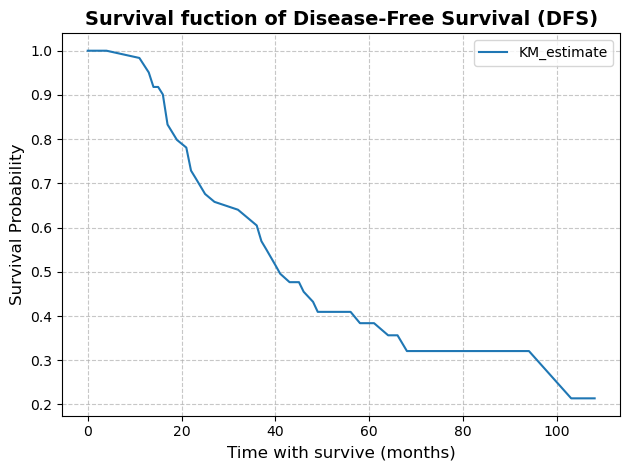

In [18]:
kmf.survival_function_.plot();
plt.title("Survival fuction of Disease-Free Survival (DFS)", fontsize=14, fontweight='bold')
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- The Kaplan-Meier curve shows a **gradual decline** in survival probability, with the steepest drop in the first **40 months**.
- The **median DFS** is approximately **40 months**, indicating that **50% of patients** experience disease recurrence or death by this time.
- A small subset of patients maintains disease-free survival for **100+ months**, with survival probability stabilizing around **20%**.

### **Error bars**

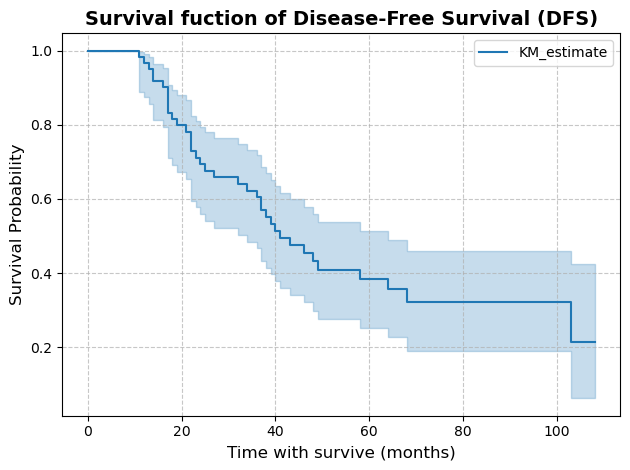

In [19]:
kmf.plot_survival_function()
plt.title("Survival fuction of Disease-Free Survival (DFS)", fontsize=14, fontweight='bold')
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- At earlier time points (e.g., **0–40 months**), confidence intervals (shaded regions) are narrower, reflecting higher certainty due to a larger number of patients and observations.
- As survival time increases (e.g., **beyond 60 months**), fewer patients remain under observation, resulting in wider intervals and greater uncertainty in survival probability estimates.

## **Cox proportional hazards model**

In [20]:
cph = lifelines.CoxPHFitter(penalizer=0.1)
cph.fit(cancer_df_surv, duration_col="DFS (in months)", event_col="DFS event")

<lifelines.CoxPHFitter: fitted with 62 total observations, 25 right-censored observations>

<Axes: xlabel='log(HR) (95% CI)'>

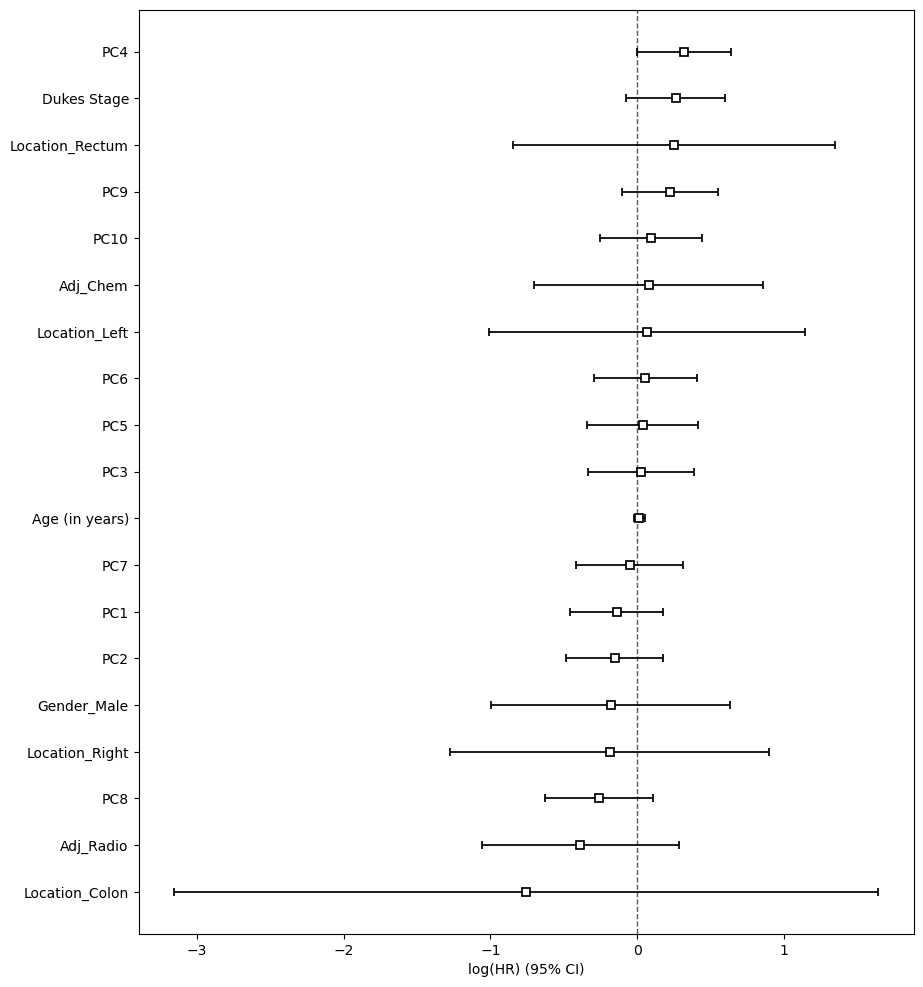

In [21]:
plt.figure(figsize=(10, 12))
cph.plot()

- **Significant Predictors**:
   - **Dukes Stage**: Positive coefficient with a narrow CI that does not cross 0, indicating it significantly increases the hazard (higher risk of the event).
   - **Adj_Chem**: Negative coefficient with a CI that does not cross 0, suggesting it significantly reduces the hazard ((lower risk of the event).

- **Non-Significant Predictors**:
   - Features like **PC9**, **PC10**, **Gender_Male**, and **Location_Colon** have wide CIs that cross 0, indicating no statistically significant effect on the hazard.

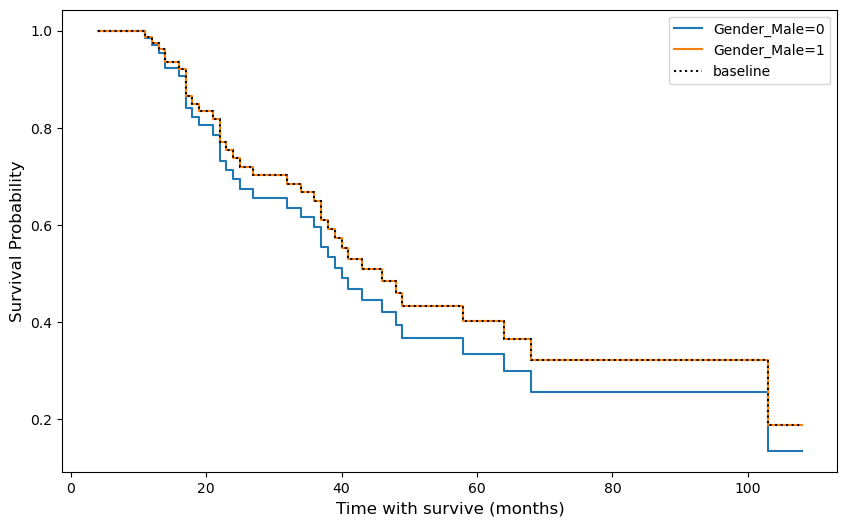

In [22]:
cph.plot_partial_effects_on_outcome("Gender_Male", [0, 1])
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.gcf().set_size_inches(10, 6)

- **Gender Differences in Survival**:
   - The survival probability for **males** is slightly higher than for **females** across most of the observation period.
   - This indicates that males may have a marginally better survival rate in this dataset.

- **No Significant Divergence**:
   - The survival curves for both genders follow a similar trend, with no substantial divergence observed, suggesting gender may not have a strong impact on survival.


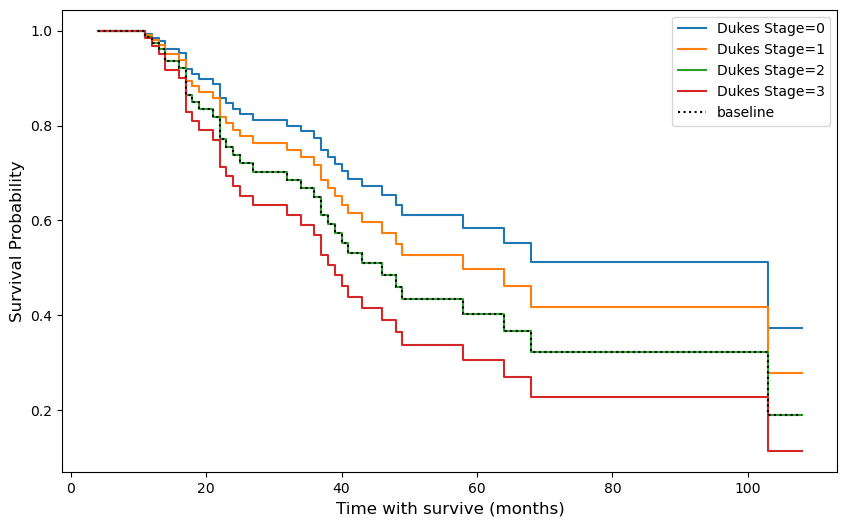

In [23]:
cph.plot_partial_effects_on_outcome("Dukes Stage", [0, 1, 2, 3])
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.gcf().set_size_inches(10, 6)

- **Trend Over Time**:
   - Survival probability decreases for all stages over time, but the rate of decline is faster for higher stages (e.g., Dukes Stage 2 and 3).
   - The survival curves are well-separated by stage, reflecting a clear impact of disease severity on survival outcomes.

- **Long-Term Survival**:
   - **Dukes Stage 0 and 1** stabilize at higher survival probabilities (~60-70%) after 80 months.
   - **Dukes Stage 3** has the lowest long-term survival (~20%).